# Advance Lane Detection Project Report
***

## Goals and Objectives
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Camera Calibration
---

Many cameras create a slight fisheye distortion because they are projecting the 3D world onto a 2D surface. By taking photos of a chessboard of known dimensions, we can create a correction matrix based on the distortion detected between the known layout of the chessboard and its appearance in the photographs. OpenCV provides built-in methods to do this (see `util/calibration.py` for implementation details).

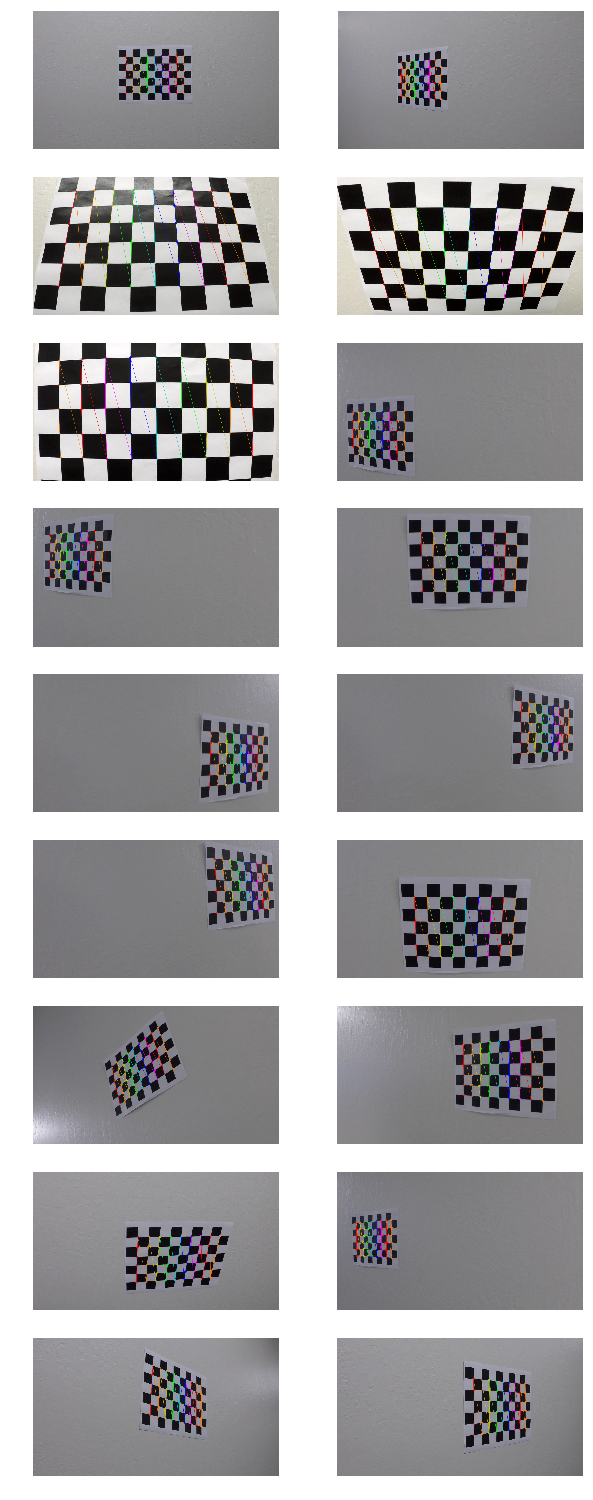

In [2]:
from utils import calibration
import glob

(ret, calibration_matrix, distortion, rvecs, tvecs), fig = calibration.get_calibration_matrix(os.path.join('camera_cal', '*.jpg'))
fig.set_size_inches(10,30)

Here is an example of an undistorted image (using `cv2.undistort` with the camera matrix and coefficients derived in the previous step).

([], <a list of 0 Text yticklabel objects>)

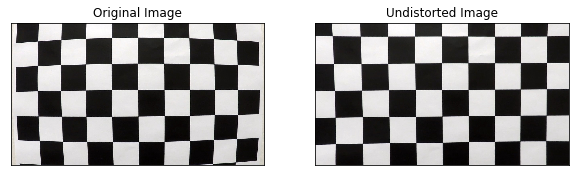

In [3]:
test_image = plt.imread(os.path.join('camera_cal', 'calibration1.jpg'))
undistorted_img = calibration.undistort(test_image, calibration_matrix, distortion)


plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.xticks([])
plt.yticks([])




## Pipeline
---

### 1. Undistorting a Image 

Here is an example of applying the same `cv2.undistort` method to a road image. The undistortion is quite noticeable in the white car on the right.

([], <a list of 0 Text yticklabel objects>)

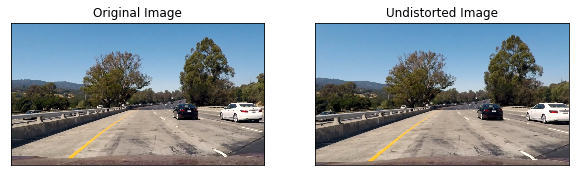

In [4]:
test_image = plt.imread(os.path.join('test_images', 'test1.jpg'))
undistorted_img = calibration.undistort(test_image, calibration_matrix, distortion)


plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.xticks([])
plt.yticks([])

### 2. Image Thresholding
This step reduces the image to a binary mask based on color thresholding and gradient magnitude thresholding. The idea is that edges exist in regions where there is a sharp contrast from one level of color/saturation intensity to another. This pre-processing step makes it easy to apply edge detection. See `utils/thresholding` for implementation details.

Text(0.5,1,'Thresholded Binary')

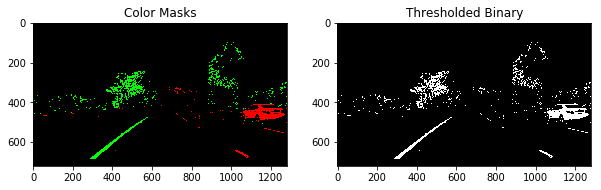

In [5]:
from utils.thresholding import *

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
thresholded = threshold(test_image, color=True)
plt.imshow(thresholded)
plt.title('Color Masks')

plt.subplot(1,2,2)
b_thresholded = threshold(test_image)
plt.imshow(b_thresholded, cmap='gray')
plt.title('Thresholded Binary')

### 2. Perspective Transformation
This is one of the coolest things I learned in the whole course. It still kind of blows my mind. I experimented with a few different sets of points in a fairly haphazard way, and one improvement I would like to try is finding a more programmatic way to tune these parameters.

Text(0.5,1,'Binary Warped Image')

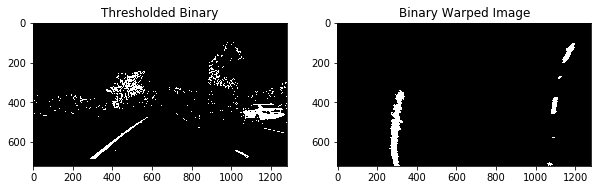

In [6]:
img_size = (b_thresholded.shape[1], b_thresholded.shape[0])
width, height = img_size
offset = 200
src = np.float32([
    [590,450],
    [700,450],
    [1100,680],
    [200,680]
    ])
dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
b_thresholded = threshold(test_image)
plt.imshow(b_thresholded, cmap='gray')
plt.title('Thresholded Binary')

plt.subplot(1,2,2)
binary_warped = cv2.warpPerspective(b_thresholded,M, (width, height))
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped Image')

### 3. Lane Detections
With the image thresholded and the perspective transformed, it is now easy to detect lanes. A histogram of where the white pixels are clustered in the bottom half of the image gives us the plausible starting points for each lane line. From these starting points we then run sliding windows as we move up the image to create two buckets of points. Finally, we fit a polynomial to each bucket to give us the estimated lane lines.

Text(0.5,1,'Lane Detected')

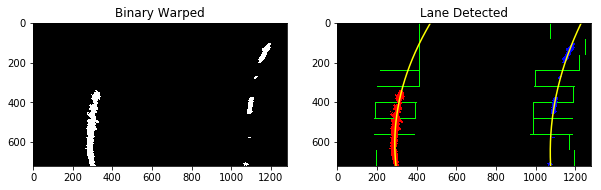

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]//2):,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Drawing the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identifing the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped')

plt.subplot(1,2,2)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Detected')

### 3. Radius of Curvature
Since we know the relative dimensions of the image to the world (they are given in the assignment) we can calculate the real life radius of curvature. For the lines detected in the first test image, it is 319.5m (i.e. traveling along the edge of a circle with a radius of 319.5m would be roughly equivalent to driving along this road at this point in time). We also know that the camera is mounted in the center of the car, so calculating the car position is simply a case of taking the difference between the midpoint of the image and the midpoint of the detected lane.

In [8]:
ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
y_eval = 700
midx = 650

y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
print("Radius of Curvature: %f" % curvature)

Radius of Curvature: 319.467688


### 4. Plot Lanes on Image
Finally, we can reverse the perspective transform (i.e. do another perspective transform with the inverse of the matrix used in the first one) and draw the lane lines on top of the original road image.


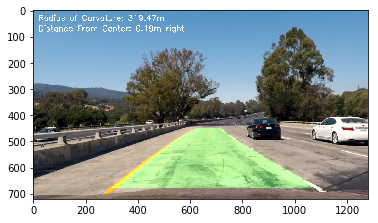

In [9]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

cv2.putText(result,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
if position_from_center < 0:
    text = 'left'
else:
    text = 'right'
cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
plt.imshow(result)

# Final Video
---

Here is the final video. A handy trick that I got from the slack channel was to use a weighted average for the polynomial fit to give smoother lines. Before applying this, I found my lines were quite jumpy. See `utils/line.py` for implementation details.

In [10]:
from utils.pipeline import Pipeline
from utils.line import Line
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pipeline=Pipeline()
line=Line()
pipeline.set_values(line, M, Minv, calibration_matrix, distortion)

project_out = 'project_video_output.mp4'
project_in = VideoFileClip("project_video.mp4")
processed = project_in.fl_image(pipeline.apply_pipeline)
%time processed.write_videofile(project_out, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_out))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:56<00:00, 10.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 43s, sys: 19.5 s, total: 3min 2s
Wall time: 1min 56s


## Discussion

I found this project really hard. In fact, I had to totally rewrite it twice. My main problem was lacking a good way to end-to-end test my pipeline except through the video output. My second implementation was able to draw lanes on the harder challenge videos, but was very slow and did not perform well enough on the main project video. My final implementation performs well on the project video but does not detect lanes on the challenge videos.

The concepts in isolation were not hard to grasp, but what I mainly struggled with was understanding/predicting how tuning parameters at each step of my pipeline would impact the final performance of the pipeline as a whole.